In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import tensorflow as tf
import os ,sys, platform
import cosmopower as cp

In [2]:
#parameter
par = {"H0":67.36, "ombh2":0.02237, "omch2":0.1200, "mnu":0.06, "omk":0, "tau":0.0544,"As":2.101e-9, "ns":0.965, "r":0} 

#params for cosmopower
params = {'omega_b': [par["ombh2"]],
          'omega_cdm': [par["omch2"]],
          'h': [par["H0"]/100],
          'tau_reio': [par["tau"]],
          'n_s': [par["ns"]],
          'ln10^{10}A_s': [np.log( 10**10 * par["As"])],
          }

In [3]:
#parameter
par = {"H0":67.36, "ombh2":0.02237, "omch2":0.1200, "mnu":0.06, "omk":0, "tau":0.0544,"As":2.101e-9, "ns":0.965, "r":0} 

#params for cosmopower
params = {'omega_b': [par["ombh2"]],
          'omega_cdm': [par["omch2"]],
          'h': [par["H0"]/100],
          'tau_reio': [par["tau"]],
          'n_s': [par["ns"]],
          'ln10^{10}A_s': [np.log( 10**10 * par["As"])],
          }

In [4]:
def Camb_pp(ell,ell_max,parameter,x,lens_accuracy=0):
    #camb model pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = par["H0"], ombh2=par["ombh2"], omch2=par["omch2"], mnu=par["mnu"], omk=par["omk"], tau=par["tau"])
    pars.InitPower.set_params(As=par["As"], ns=par["ns"], r=par["r"])
    pars.set_for_lmax(ell_max-1, lens_potential_accuracy=float(lens_accuracy));
    #camb result and power spectra
    camb_results = camb.get_results(pars)
    powers = camb_results.get_cmb_power_spectra(pars, CMB_unit="muK")#,raw_cl=True)
    
    if x == 'TT':
        #CAMB TT
        cambq = powers['lensed_scalar'][:, 0][2:ell_max]
    elif x == 'EE':
        #CAMB EE
        cambq = powers['lensed_scalar'][:, 1][2:ell_max]
    elif x == 'TE':
        #CAMB TE
        cambq = powers['lensed_scalar'][:, 3][2:ell_max]
    else:
        #CAMB TE EE
        cambq = None
    
    return cambq 

In [5]:
def plot_dif(ell,ellms,a,b,c,d , xname1 ,yname1,yname2,log1 = False,error = False,dl_fc = False):
    plt.figure(figsize=(15, 15), dpi=80)
    
    
    plot1 = plt.subplot2grid((4, 4), (0, 0), colspan=4,rowspan=2)
    plot2 = plt.subplot2grid((4, 4), (2, 0),  colspan=2,rowspan = 2)
    plot3 = plt.subplot2grid((4, 4), (2, 2), rowspan=2,  colspan=2)
    dl_fac = ell*(ell+1)/(2.*np.pi)
    #Plotting Both Plots
    if log1 is True:
        plot1.set_yscale('log')
    else:
        None
        
    
    if dl_fc == True:
        if error == True:
            err = (c*dl_fac,d*dl_fac)
            plot1.errorbar(ell, a*dl_fac, yerr = err, marker='o', mfc='red',mec='green', ms=0, mew=0.1,linewidth = 0.5)
        
        else:
            None
            
        plot1.set_ylabel(r'$ D_{\ell}$ [$\mu$K$^{2}$]', fontsize = 16)
        plot1.set_xlabel(r'Multipole $\ell$', fontsize = 16)
        plot1.plot(ell,a*dl_fac,color = 'red',label =yname1, linewidth = 1)
        plot1.plot(ell,b*dl_fac,color = 'gold',label =yname2, linewidth = 2,linestyle='-.')
        
    else:
        if error == True:
            err = (c,d)
            plot1.errorbar(ell, a, yerr = err, marker='o', mfc='red',mec='green', ms=0, mew=0.1,linewidth = 0.5)
        
        else:
            None
        plot1.set_ylabel(r'$C_{\ell}$ [$\mu$K$^{2}$]' , fontsize = 16)
        plot1.set_xlabel(r'Multipole $\ell$', fontsize = 16)
        plot1.plot(ell,a,color = 'red',label = yname1, linewidth = 1)
        plot1.plot(ell,b,color = 'gold',label = yname2, linewidth = 2,linestyle='-.')
        
    plot1.set_xlim(0,ellms)
    plot1.set_title('Comparison of '+yname1+yname2+'--'+xname1)
    plot1.legend(fontsize=20)
    
    #Difference of plot with log
    
    difs = (a - b)/a
    plot2.set_title(yname1+" and "+ yname2+ "--" + xname1)
    
    plot2.plot(ell,difs,color = 'blue',lw = 1.5)
    plot2.set_ylabel(r'('+ yname1 +' C $\ell$ - '+ yname2 +' C $\ell$ )/' + yname2 + '  C$\ell$', fontsize = 16)
    plot2.set_xlabel(r'Multipole $\ell$', fontsize = 16)
    plot2.set_xlim(0,ellms)
    
    #diff with log
    plot3.set_title(yname1+" and "+ yname2+ "--" + xname1)
    
    plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)
    plot3.set_ylabel(r'log(('+ yname1 +' C $\ell$ - '+ yname2 +' C $\ell$ )/' + yname2 + '  C$\ell$)', fontsize = 16)
    plot3.set_xlabel(r'Multipole $\ell$', fontsize = 14)
    plot3.set_xlim(0,ellms)
  
    # Packing all the plots and displaying them

    plt.tight_layout()
    plt.savefig('Comparison of '+yname1+yname2+'--'+xname1)
    plt.show()
    
    
    
    

In [6]:
#COSMOPOWER TE EE
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')

te_spectra = te_emu.predictions_np(params)
ee_spectra = ee_emu.ten_to_predictions_np(params)
tt_spectra = tt_emu.ten_to_predictions_np(params)

#COSMOPOWER TE EE
CO_te = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
CO_ee = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
CO_tt = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2

In [9]:
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_20388\238568400.py:58: RuntimeWarning: invalid value encountered in log
  plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)


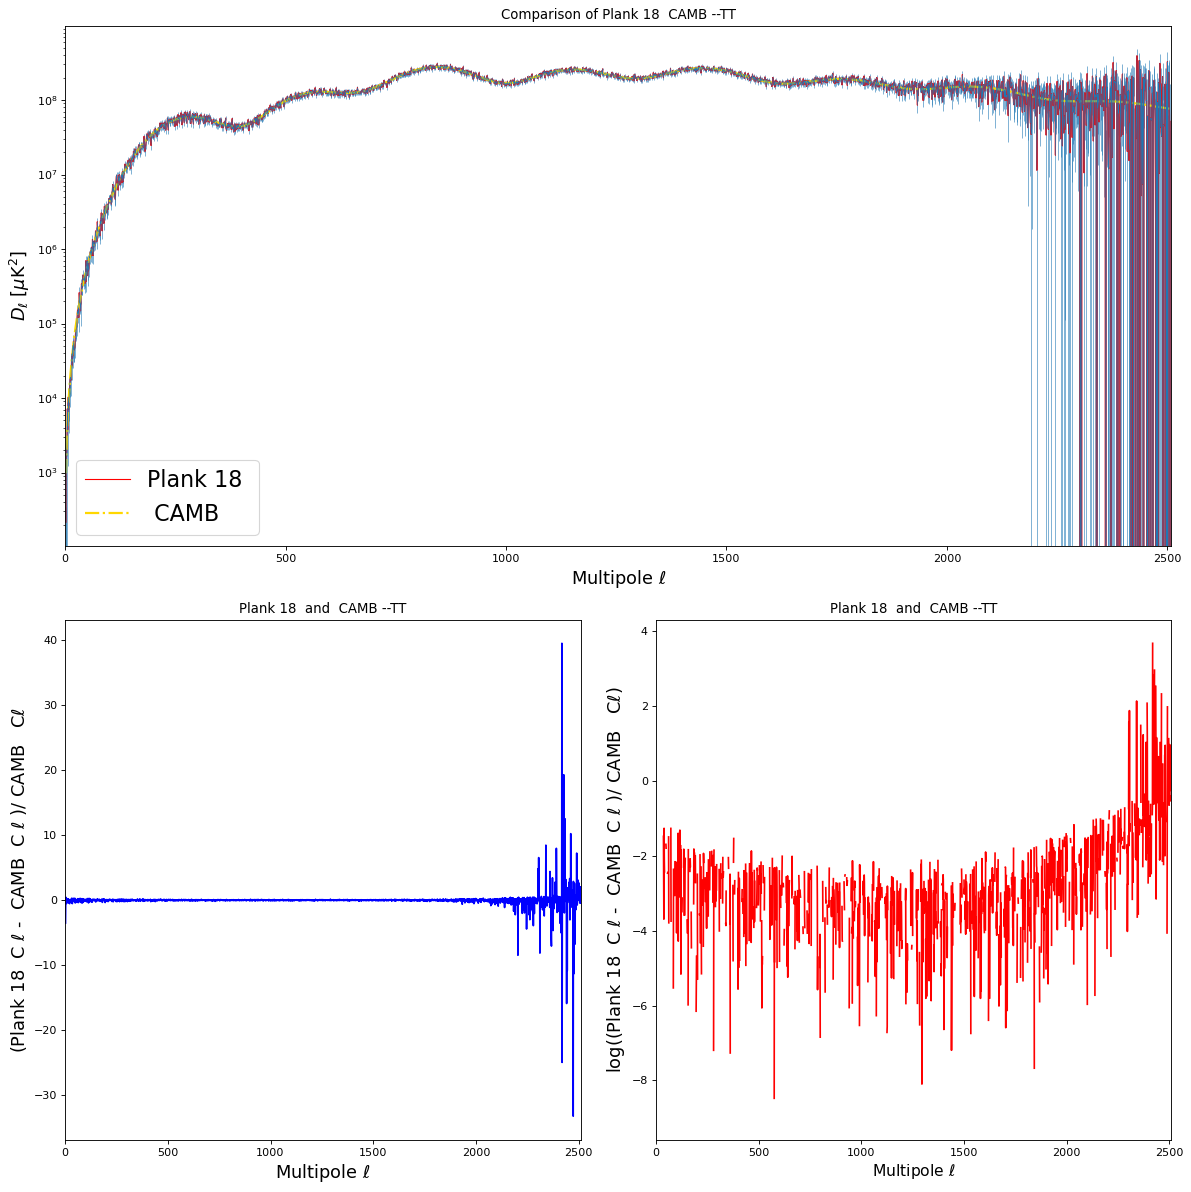

In [12]:
ellm = 2509
ells = np.arange(2,ellm,1)
ptt = Camb_pp(ells,ellm,par,'TT')
plot_dif(ells,ellm,Dl_TT,ptt,Dl_TT_err_up,Dl_TT_err_bot,'TT','Plank 18 ',' CAMB ',True,True,True)

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_20388\238568400.py:58: RuntimeWarning: invalid value encountered in log
  plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)


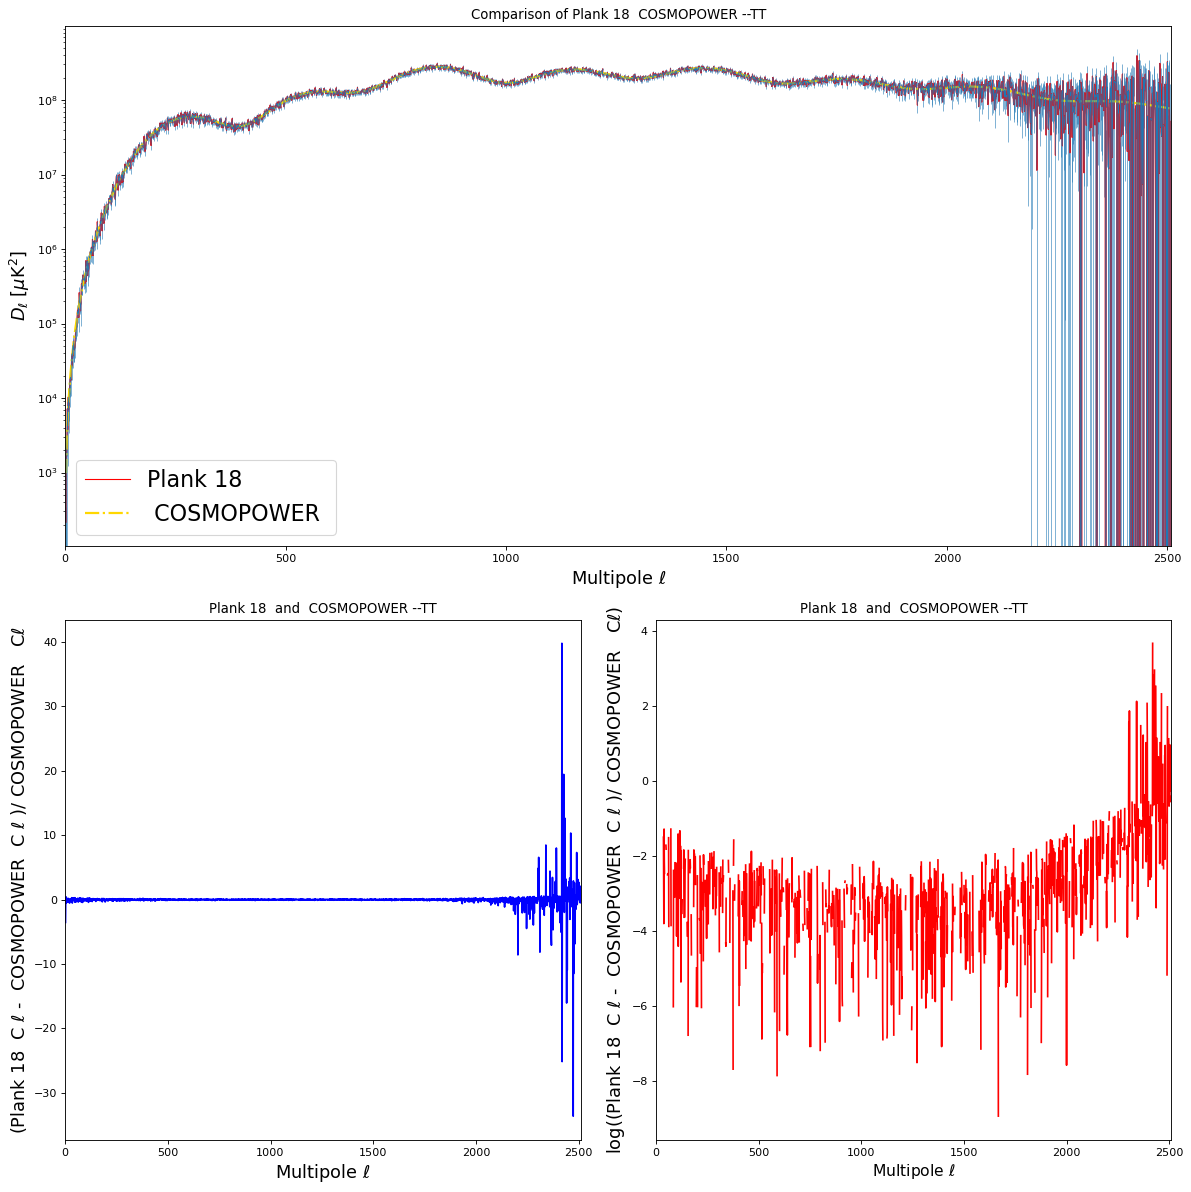

In [11]:
ellm = 2509
ells = np.arange(2,ellm,1)
ptt = CO_tt*ells*(ells+1)/(2.*np.pi)
plot_dif(ells,ellm,Dl_TT,ptt,Dl_TT_err_up,Dl_TT_err_bot,'TT','Plank 18 ',' COSMOPOWER ',True,True,True)

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_20988\238568400.py:58: RuntimeWarning: invalid value encountered in log
  plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)


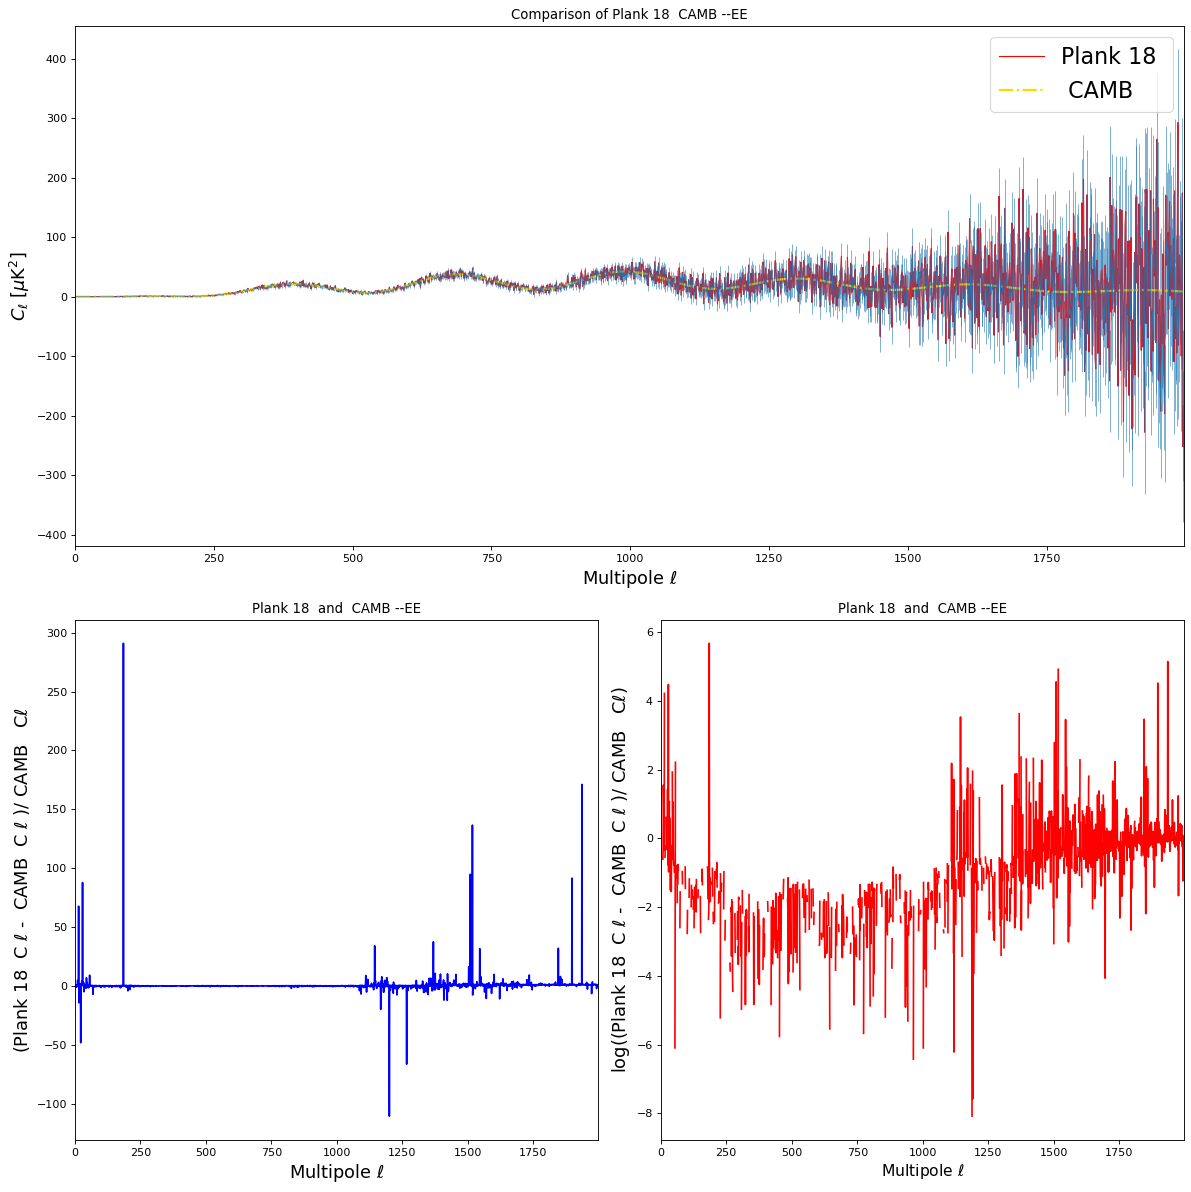

In [221]:
ellm = 1997
ells = np.arange(2,ellm,1)
ptt = Camb_pp(ells,ellm,par,'EE')
plot_dif(ells,ellm,Dl_EE,ptt,Dl_EE_err_up,Dl_EE_err_bot,'EE','Plank 18 ',' CAMB ',False,True,False)

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_20988\238568400.py:58: RuntimeWarning: invalid value encountered in log
  plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)


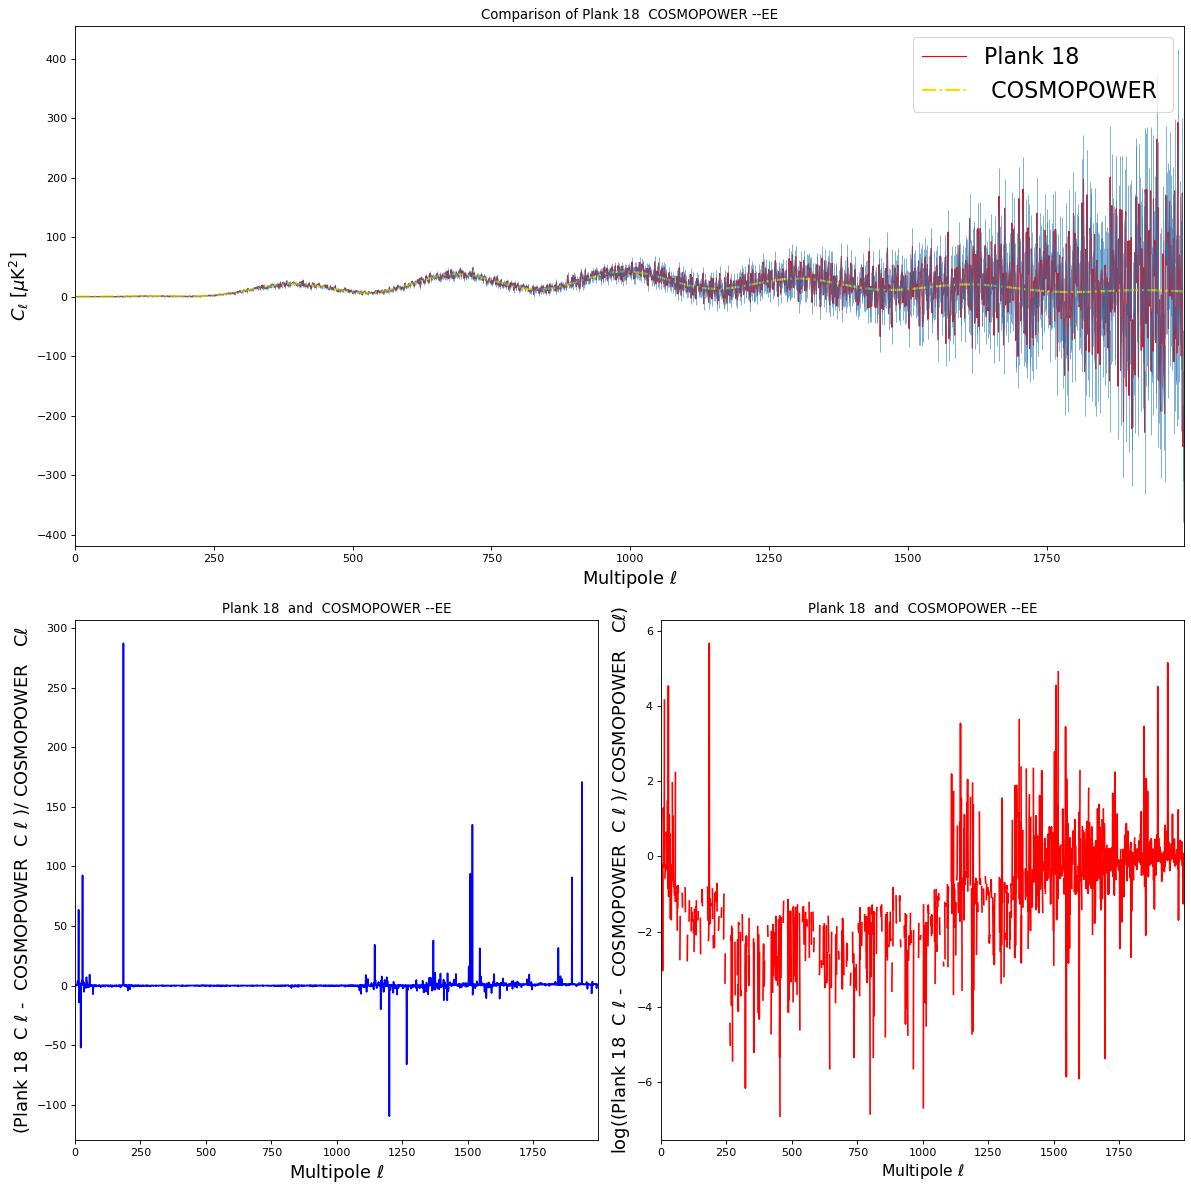

In [222]:
ellm = 1997
ells = np.arange(2,ellm,1)
ptt = CO_ee[1:ellm-1]*ells*(ells+1)/(2.*np.pi) 
plot_dif(ells,ellm,Dl_EE,ptt,Dl_EE_err_up,Dl_EE_err_bot,'EE','Plank 18 ',' COSMOPOWER ',False,True,False)

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_20988\238568400.py:58: RuntimeWarning: invalid value encountered in log
  plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)


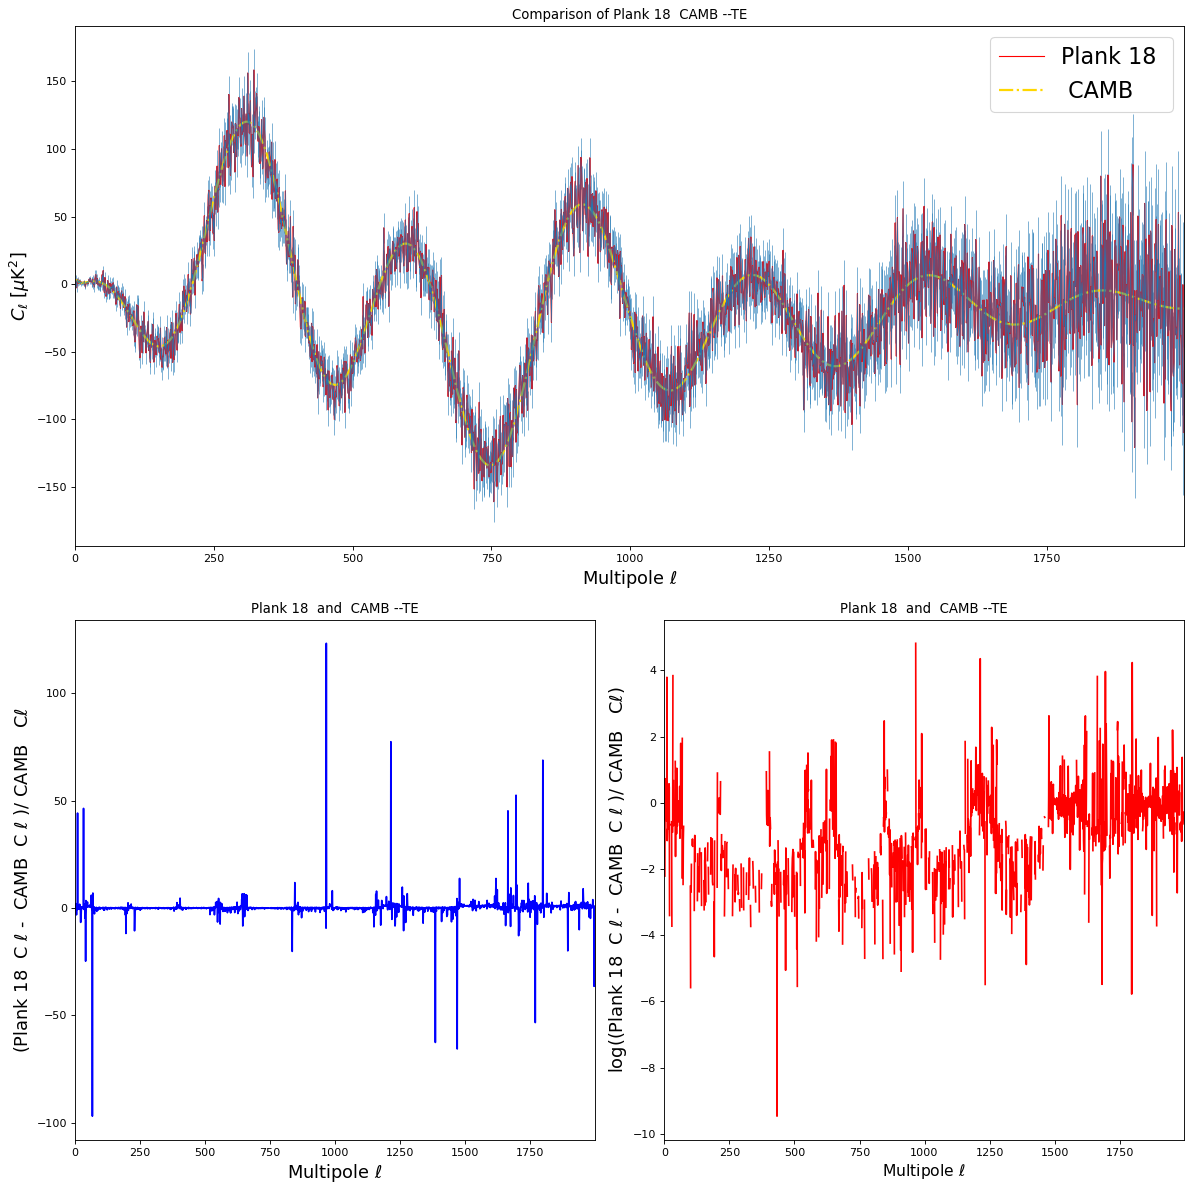

In [223]:
ellm = 1997
ells = np.arange(2,ellm,1)
ptt = Camb_pp(ells,ellm,par,'TE')
plot_dif(ells,ellm,Dl_TE,ptt,Dl_TE_err_up,Dl_TE_err_bot,'TE','Plank 18 ',' CAMB ',False,True,False)

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_20988\238568400.py:58: RuntimeWarning: invalid value encountered in log
  plot3.plot(ell,np.log(difs),color = 'red',lw = 1.5)


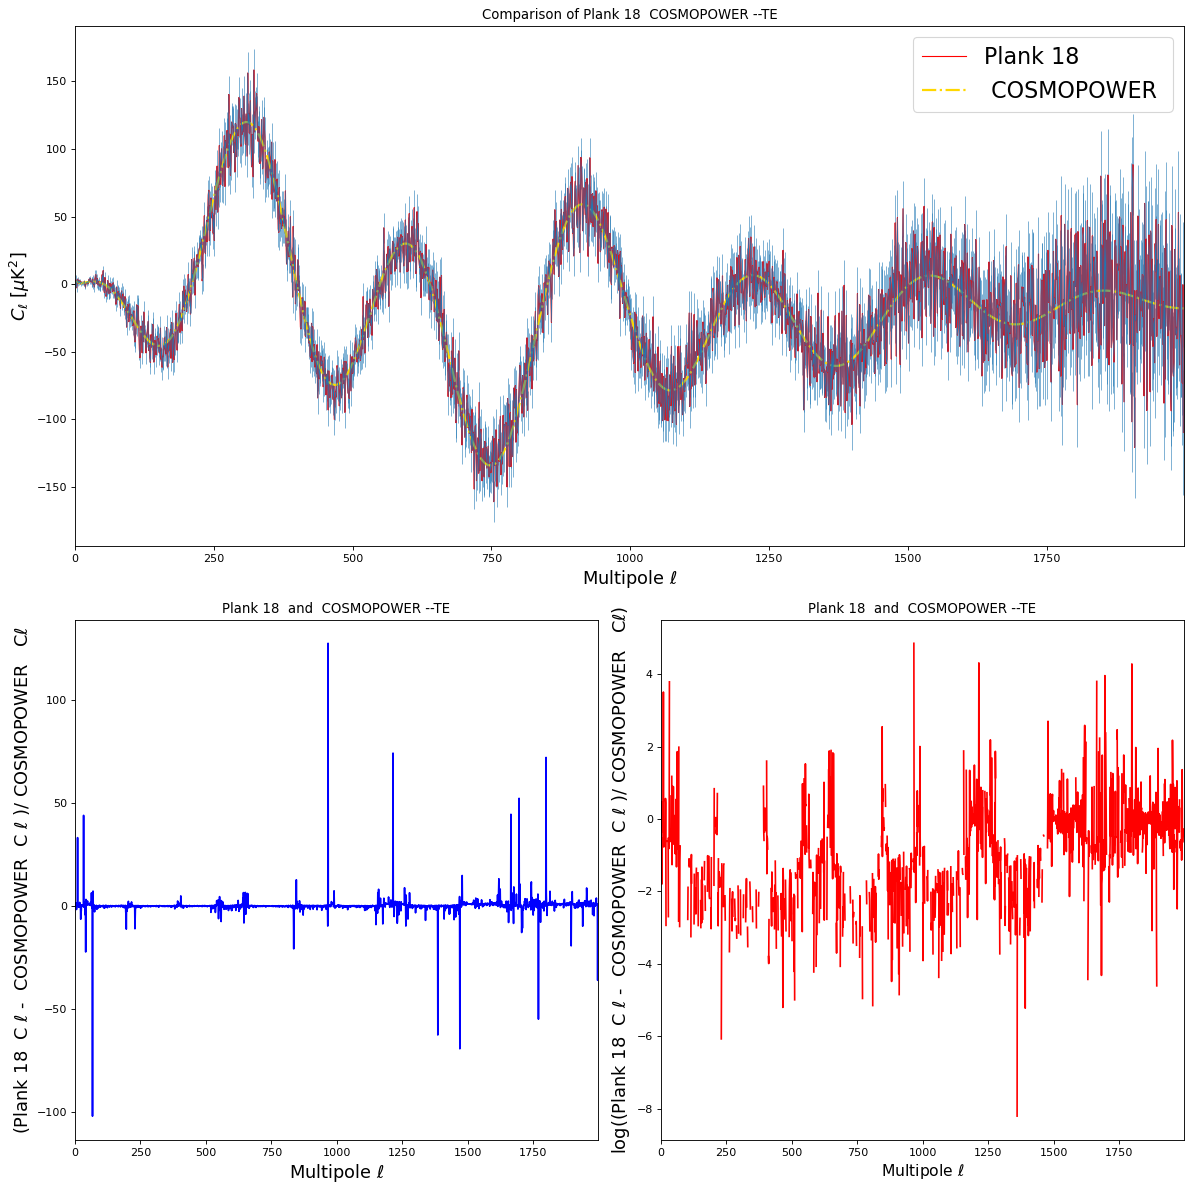

In [230]:
ellm = 1997
ells = np.arange(2,ellm,1)
ptt = CO_te[1:ellm-1]*ells*(ells+1)/(2.*np.pi)
plot_dif(ells,ellm,Dl_TE,ptt,Dl_TE_err_up,Dl_TE_err_bot,'TE','Plank 18 ',' COSMOPOWER ',False,True,False)

In [ ]:
'''start_time = time.time() #time calculation
chi2_arr_TTE = [[],[],[]]
input_range = np.arange(0.05,0.06,0.0001) #range
for val in input_range:    
    #params for cosmopower
    params = {'omega_b': [0.019],#0.02237],
              'omega_cdm': [0.12],#1200],#0.47],#0.1200],
              'h': [67.36/100],
              'tau_reio': [val],#0.0544],
              'n_s': [0.945],#0.83],#0.945],#0.964
              'ln10^{10}A_s': [3.0449],#3.629
              }

    pred_TT = Cosmo('TT',params)
    chi_TT = chi2(Dl_TT,Dl_TT_err_up,Dl_TT_err_bot,pred_TT)
    chi2_arr_TTE[0].append(chi)
        
    pred_TE = Cosmo('TE',params)
    chi_TE = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred_TE)
    chi2_arr_TTE[1].append(chi_TE)
    
    pred_EE = Cosmo('EE',params)
    chi_EE = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    chi2_arr_TTE[2].append(chi_EE)
        
    

end_time = time.time()

''''''#plotting  the chi2 and the input value
plt.plot(input_range,chi2_arr)
plt.xlabel('n_s')#change name based input
plt.ylabel('CHI^2')
''''''
#finding the input value for the  minimum chi2 value
min_chi2_TT = np.argmin(chi2_arr_TTE[0]) #position of minimum chi2
vals_TT = input_range[min_chi2_TT] #finding Input value of minimum chi2
#finding the input value for the  minimum chi2 value
min_chi2_EE = np.argmin(chi2_arr_TTE[2]) #position of minimum chi2
vals_EE = input_range[min_chi2_EE] #finding Input value of minimum chi2
#finding the input value for the  minimum chi2 value
min_chi2_TE = np.argmin(chi2_arr_TTE[1]) #position of minimum chi2
vals_TE = input_range[min_chi2_TE] #finding Input value of minimum chi2

tim = time_hr(end_time - start_time) # finding time for excution
total_values = np.shape(input_range)[0]

plt.plot(input_range,chi2_arr_TTE[0], color='green',  linestyle='dashed')
#plt.plot(input_range,chi2_arr_TTE[1], color='blue',  linestyle='dotted')
#plt.plot(input_range,chi2_arr_TTE[2], color='red')
print('The Best Fitted input Value is','TT' ,vals_TT ,'having the chi^2 value is',min_chi2_TT )
print('The Best Fitted input Value is','EE' ,vals_EE ,'having the chi^2 value is',min_chi2_EE )
print('The Best Fitted input Value is','TE' ,vals_TE ,'having the chi^2 value is',min_chi2_TE )
print( 'Total simulations of',total_values,'Executed in :',tim[4],'days,',tim[3],'Hours,',tim[2] ,'Minute',tim[1],'seconds',tim[0],'Miliseconds')'''